Problem description: We have data about users who hit our site: whether they converted or not as well as some of their characteristics such as their country, the marketing channel, their age, whether they are repeat users and the number of pages visited during that session (as a proxy for site activity/time spent on site). Our aim to is to come up with 1) Prediction of conversion rate 2) Come up with recommendations for ht eproduct team and the markerting team to improve conversion rate

Some interesting sites:
* https://www.dataquest.io/blog/matplotlib-tutorial/

In [357]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import accuracy_score

Step 1: Let us load the data and have a brief look at it.

In [358]:
conversion_data=pd.read_csv('conversion_data.csv',sep=',')
conversion_data.head()

,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0


In [359]:
visitor_by_countries=conversion_data['country']
for countries in visitor_by_countries.unique():
    print(countries,conversion_data[visitor_by_countries==countries].count().country)
#buyers_by_countries=visitor_by_countries[visitor_by_countries['converted']==1]
visitor_by_countries.head()

UK 48450
US 178092
China 76602
Germany 13056


0       UK
1       US
2       US
3    China
4       US
Name: country, dtype: object

Get some insight into the data

Columns:
* country : user country based on the IP address
* age : user age. Self-reported at sign-in step
* new_user : whether the user created the account during this session or had already an account and simply came back to the site
* source : marketing channel source
 * Ads: came to the site by clicking on an advertisement 
 * Seo: came to the site by clicking on search results
 * Direct: came to the site by directly typing the URL on the browser
* total_pages_visited: number of total pages visited during the session. This is a proxy for time spent on site and engagement during the session.
* converted: this is our label. 1 means they converted within the session, 0 means they left without buying anything. The company goal is to increase conversion rate: # conversions / total sessions.
    

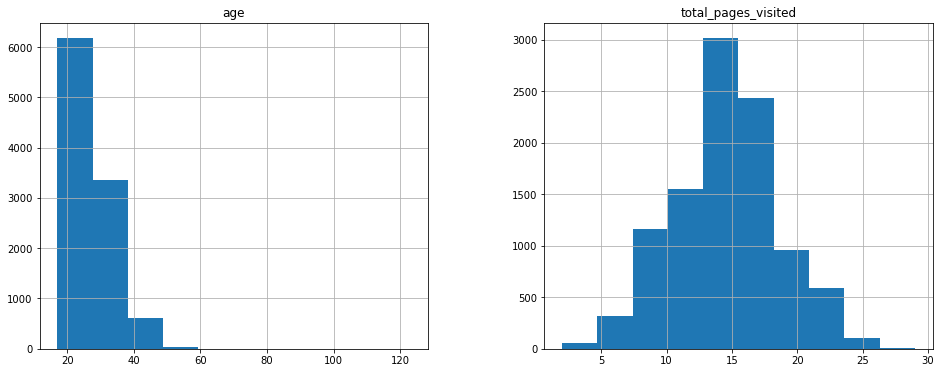

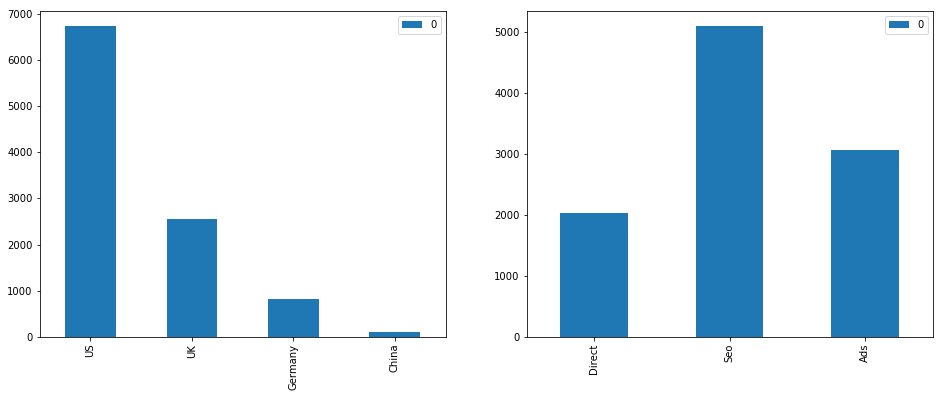

In [360]:
#Stats about visits that converted into purchases
a=(conversion_data[conversion_data['converted']==1])
pd.DataFrame.hist(a,column=["age","total_pages_visited"],figsize=(16,6))
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(16,6))
pd.DataFrame.from_dict(Counter(a.country), orient='index').plot(kind='bar',ax=axes[0])
pd.DataFrame.from_dict(Counter(a.source), orient='index').plot(kind='bar',ax=axes[1])
plt.show()

Conclusions about visitors who bought something
* Most of the buyers are between 20-40 years of age
* Most of the buyers visit 12-17 pages. Perhaps they are interested in some other items too.
* Most of the customers are from USA followed by UK, Germany and China (Perhaps language is a barrier)
* Most of the serious buyers visit the website through online searches.

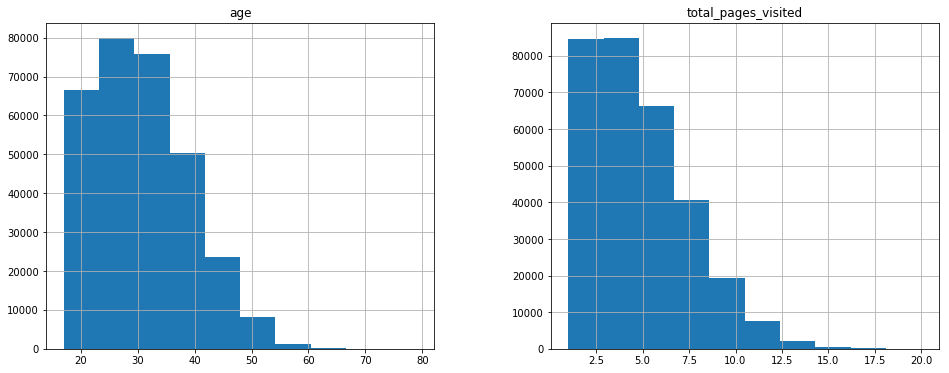

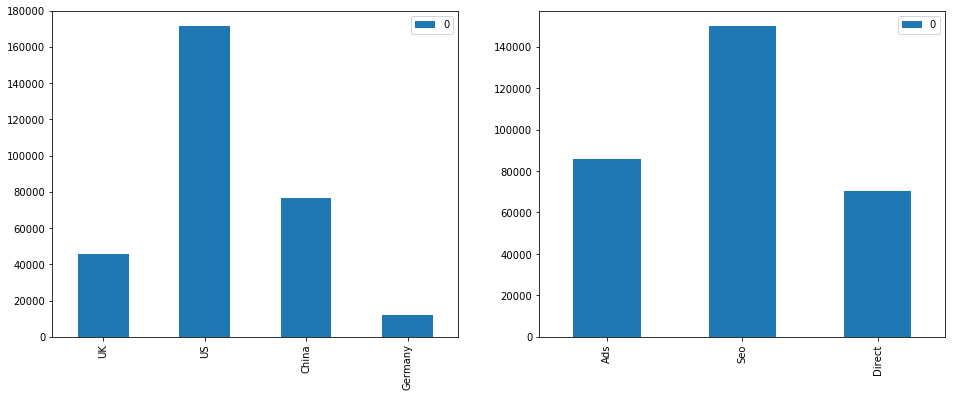

In [361]:
#Stats about visits that didn't convert into purchases
b=(conversion_data[conversion_data['converted']==0])
pd.DataFrame.hist(b,column=["age","total_pages_visited"],figsize=(16,6))
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(16,6))
pd.DataFrame.from_dict(Counter(b.country), orient='index').plot(kind='bar',ax=axes[0])
pd.DataFrame.from_dict(Counter(b.source), orient='index').plot(kind='bar',ax=axes[1])
plt.show()

In [362]:
buyers_by_countries    = pd.DataFrame.from_dict(Counter(a.country), orient='index').reset_index()
nonbuyers_by_countries = pd.DataFrame.from_dict(Counter(b.country), orient='index').reset_index()
buyers_by_countries = buyers_by_countries.sort_values(by="index",ascending=True)
nonbuyers_by_countries = nonbuyers_by_countries.sort_values(by="index",ascending=True)
buyers_by_countries = buyers_by_countries.values
nonbuyers_by_countries = nonbuyers_by_countries.values
#print("Number of buyers from different countries",buyers_by_countries)
#print("Number of non buyers from different countries", nonbuyers_by_countries)
buyers_by_percentage=buyers_by_countries[:,1]/(buyers_by_countries[:,1]+nonbuyers_by_countries[:,1])*100
for i in range(len(buyers_by_percentage)):
    print(buyers_by_countries[i,0],buyers_by_percentage[i])

China 0.13315579227696406
Germany 6.25
UK 5.263157894736842
US 3.7800687285223367


Conver the categorical data into numerical vlaues

In [363]:
conversion_data['country_code'] = pd.Categorical(conversion_data["country"]).codes
conversion_data['source_code'] = pd.Categorical(conversion_data["source"]).codes
conversion_data.head()

,country,age,new_user,source,total_pages_visited,converted,country_code,source_code
0,UK,25,1,Ads,1,0,2,0
1,US,23,1,Seo,5,0,3,2
2,US,28,1,Seo,4,0,3,2
3,China,39,1,Seo,5,0,0,2
4,US,30,1,Seo,6,0,3,2


One hot encoding

In [364]:
conversion_data= pd.get_dummies(conversion_data,columns=["country_code","source_code","new_user"],prefix=["cc","sc","nu"])

In [365]:
conversion_data.head()
conversion_data = conversion_data.drop(["country","source"],axis=1)
conversion_data.head()

,age,total_pages_visited,converted,cc_0,cc_1,cc_2,cc_3,sc_0,sc_1,sc_2,nu_0,nu_1
0,25,1,0,0,0,1,0,1,0,0,0,1
1,23,5,0,0,0,0,1,0,0,1,0,1
2,28,4,0,0,0,0,1,0,0,1,0,1
3,39,5,0,1,0,0,0,0,0,1,0,1
4,30,6,0,0,0,0,1,0,0,1,0,1


In [366]:
y=conversion_data['converted']
X=conversion_data.drop(["converted"],axis=1).values

In [367]:
#Split the data into training and validation test
X_train, X_val, y_train, y_val =  train_test_split(X,y,test_size=0.2,random_state = 0)

In [368]:
lambda_=1e-5
logreg = linear_model.LogisticRegression(C=1/lambda_)
logreg.fit(X_train, y_train)
predictions=logreg.predict(X_train)
print('Accuracy on the training set', accuracy_score(y_train, predictions))
print('Accuracy on the test set', accuracy_score(y_val,logreg.predict(X_val)))

Accuracy on the training set 0.986211258697
Accuracy on the test set 0.985910815939


In [369]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import np_utils
m,input_layer_size =X_train.shape
num_labels = 2
#One hot encoding
y = np_utils.to_categorical(y_train)
ANN_classifier = Sequential()
ANN_classifier.add(Dense(units = 6, kernel_initializer = 'uniform', activation = 'relu', input_dim = input_layer_size))
ANN_classifier.add(Dense(units = 6, kernel_initializer = 'uniform', activation = 'relu'))
ANN_classifier.add(Dense(units = num_labels, kernel_initializer = 'uniform', activation = 'softmax'))
ANN_classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
history=ANN_classifier.fit(X_train, y, batch_size = 100, epochs = 5)

Epoch 1/5
252960/252960 [==============================] - 3s - loss: 0.0903 - acc: 0.9758     
Epoch 2/5
252960/252960 [==============================] - 2s - loss: 0.0440 - acc: 0.9852     - ETA: 0s - loss: 0.0440 - acc: 0.985
Epoch 3/5
252960/252960 [==============================] - 2s - loss: 0.0415 - acc: 0.9860     
Epoch 4/5
252960/252960 [==============================] - 2s - loss: 0.0412 - acc: 0.9861     
Epoch 5/5
252960/252960 [==============================] - 2s - loss: 0.0411 - acc: 0.9860     


In [370]:
print('Accuracy on the training set', accuracy_score(y_train,np.argmax(ANN_classifier.predict(X_train),axis=1)))
print('Accuracy on the test set', accuracy_score(y_val,np.argmax(ANN_classifier.predict(X_val),axis=1)))

Accuracy on the training set 0.986215211891
Accuracy on the test set 0.985673624288
